### Legacy Survey Map

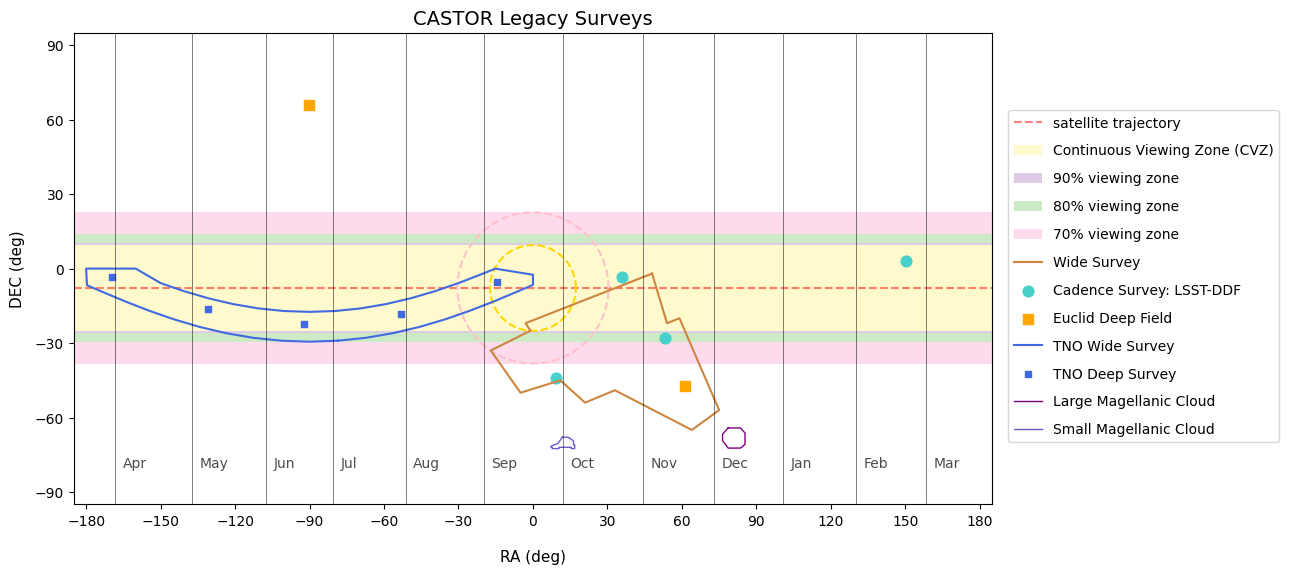

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
from shapely.geometry import MultiPolygon, Polygon

def AngleFromCVZ(viewfrac):
    AngFromCVZ = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=0)
    ViewFrac = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=4)
    interp = interp1d(ViewFrac, AngFromCVZ, kind='linear')
    return float(interp(viewfrac))

def normalize_ra(ra):
    # Normalize RA values to the range [-180, 180] degrees.
    while ra >= 180:
        ra -= 360
    while ra < -180:
        ra += 360
    return ra
    
def Circle(cx, cy, r, num=50):
    increment = 2*np.pi / num
    boundary = []
    for i in range(num):
        angle = i * increment
        x = cx + r * np.cos(angle)
        y = cy + r * np.sin(angle)
        boundary.append((x, y))
    boundary.append(boundary[0])
    return np.array(boundary)

""" Survey Coordinates """
# Coordinates Conversions
def RAdeg(hr, min, sec):
    degrees = (hr + min/60 + sec/3600) * 15
    return degrees
def DECdeg(deg, arcmin, arcsec):
    degrees = deg + arcmin/60 + arcsec/60
    return degrees

Wide = np.loadtxt('Wide.txt', skiprows=1) 

# The center coordinates of the four LSST Deep Drilling Fields
ELAIS_S1 = [RAdeg(0,37,48), DECdeg(-44,0,0)]
XMM_LSS = [RAdeg(2,22,50), DECdeg(-4,45,0)]
Chandra = [RAdeg(3,32,30), DECdeg(-28,6,0)]
COSMOS = [RAdeg(10,0,24), DECdeg(2,10,55)]
# The center coordinates of Euclid Deep Field
EDFN = [normalize_ra(RAdeg(17,58,56)), DECdeg(66,1,3.7)]
EDFS = [RAdeg(4,4,58), DECdeg(-48,25,23)]

NGS = np.genfromtxt('NGS_sample.csv', delimiter=',', skip_header=1, usecols=(0,1))
NGS[:,0] = np.vectorize(normalize_ra)(NGS[:,0])

TNO = np.loadtxt('TNO_wide.txt', skiprows=2) 
TNO = np.concatenate((TNO[:23], np.flipud(TNO[23:]), [TNO[0]]), axis=0)
TNO[:,0] = np.vectorize(normalize_ra)(TNO[:,0])

def TNOdeep_Footprint(tlx, tly):
    # 4x6 grid, 24 tiles; total area of ~6 deg^2
    L = (900*2+26)/3600 * 4 # deg
    W = (800*2+26)/3600 * 6 # deg
    return np.array([[tlx, tly], [tlx+L, tly], [tlx+L, tly-W], [tlx, tly-W], [tlx, tly]])

# center coordinates of the LMC and SMC surveys
LMCcx, LMCcy = RAdeg(5,23,34), DECdeg(-69, 45.4, 0)
SMCcx, SMCcy = RAdeg(0,52,44.8), DECdeg(-72, 49, 43)
# footprint boundary coordinates
LMC_coords = np.loadtxt('LMC.txt')
SMC_coords = np.loadtxt('SMC.txt')
LMCcolor = 'purple'
SMCcolor = 'slateblue'

""" Plots """
fig, ax = plt.subplots(1,1,figsize=(13,9))
ax.axis([-185, 185, -95, 95])
ax.set_aspect('equal')

""" Viewing Zones """
earthLimbAngle = 62.7 # deg
earthExclAngle = 10 # deg
cvzHalfAngle = 90 - earthLimbAngle - earthExclAngle # deg
vis90 = AngleFromCVZ(0.9) # deg
vis80 = AngleFromCVZ(0.8) # deg
vis70 = AngleFromCVZ(0.7) # deg
orbitInc = -7.8 # deg
# satellite trajectory
plt.axhline(y=orbitInc, linestyle='--', color='red', alpha=0.5, label='satellite trajectory')
uplim100, lolim100 = orbitInc+cvzHalfAngle, orbitInc-cvzHalfAngle
uplim90, lolim90 = orbitInc+vis90, orbitInc-vis90
uplim80, lolim80 = orbitInc+vis80, orbitInc-vis80
uplim70, lolim70 = orbitInc+vis70, orbitInc-vis70
ax.plot(Circle(0, orbitInc, r=cvzHalfAngle)[:,0], Circle(0, orbitInc, r=cvzHalfAngle)[:,1], color='gold', linestyle='--')
ax.plot(Circle(0, orbitInc, r=vis70)[:,0], Circle(0, orbitInc, r=vis70)[:,1], color='pink', linestyle='--')
cmap = plt.colormaps["Pastel1"]
ax.axhspan(lolim100, uplim100, facecolor='lemonchiffon', label='Continuous Viewing Zone (CVZ)')
ax.axhspan(lolim90, lolim100, facecolor=cmap([3]), label='90% viewing zone')
ax.axhspan(uplim100, uplim90, facecolor=cmap([3]))
ax.axhspan(lolim80, lolim90, facecolor=cmap([2]), label='80% viewing zone')
ax.axhspan(uplim90, uplim80, facecolor=cmap([2]))
ax.axhspan(lolim70, lolim80, facecolor=cmap([7]), label='70% viewing zone')
ax.axhspan(uplim80, uplim70, facecolor=cmap([7]))

""" Wide Survey """
ax.plot(Wide[:,0], Wide[:,1], color='peru', label='Wide Survey')

""" Nearby Galaxy Survey """
# ax.scatter(NGS[:,0], NGS[:,1], color='lightgray', s=10, label='Nearby Galaxies Survey')

""" Cadence Survey """
ax.scatter(ELAIS_S1[0], ELAIS_S1[1], color='mediumturquoise', s=60, label='Cadence Survey: LSST-DDF')
ax.scatter(XMM_LSS[0], XMM_LSS[1], color='mediumturquoise', s=60)
ax.scatter(Chandra[0], Chandra[1], color='mediumturquoise', s=60)
ax.scatter(COSMOS[0], COSMOS[1], color='mediumturquoise', s=60)

""" Euclid Deep Fields """
ax.scatter(EDFN[0], EDFN[1], color='orange', marker='s', s=60, label='Euclid Deep Field')
ax.scatter(EDFS[0], EDFS[1], color='orange', marker='s', s=60)

""" TNO Wide Survey """
ax.plot(TNO[:,0], TNO[:,1], color='royalblue', label='TNO Wide Survey')
""" TNO Deep Survey """
xmin, ymin, xmax, ymax = Polygon(TNO).bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = np.array([-3, -16, -22, -18, -5])
ax.scatter(xDeep+0.4, yDeep-0.4, marker='s', s=20, color='royalblue', label='TNO Deep Survey')
# for x, y in zip(xDeep, yDeep):
#     ax.fill(*zip(*TNOdeep_Footprint(x, y)), color='royalblue')

""" Magellanic Cloud Survey """
ax.plot(LMC_coords[:,0], LMC_coords[:,1], linewidth=1, color=LMCcolor, label='Large Magellanic Cloud')
ax.plot(SMC_coords[:,0], SMC_coords[:,1], linewidth=1, color=SMCcolor, label='Small Magellanic Cloud')

# lamda is "sun" ecliptic longitude --> lamda = 0° on March 21st for Sun 
# on March 21 st, CVZ will center on lamda = -180°
# CVZ sweeps clockwise across the sky 
def direction(lamda):
    RA = []
    for i in lamda:
        RA.append(i + 2.45 * math.sin(math.radians(2*i)))
    return RA
# traverse from March 21st onwards
lamda = np.arange(-180, 180, step=360/365.25)
# gives the daily position starting on March 21st. 
traverse = direction(lamda)
# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]
for i, name in zip(index, month):
    plt.axvline(x=traverse[i], color='black', alpha=0.7, linewidth=0.5)
    ax.text(traverse[i]+3, -80, name, alpha=0.7)

plt.xticks(np.arange(-180, 210, step=30))
plt.yticks(np.arange(-90, 120, step=30))
plt.xlabel('RA (deg)', fontsize=11, labelpad=15)
plt.ylabel('DEC (deg)', fontsize=11, labelpad=7)
plt.title('CASTOR Legacy Surveys', fontsize=14)
ax.legend(bbox_to_anchor=(1.01, 0.85), loc='upper left', labelspacing=1, fontsize=10)
plt.tight_layout()
plt.savefig('Survey Map.pdf')

### Viewing zone in an orbit around Earth

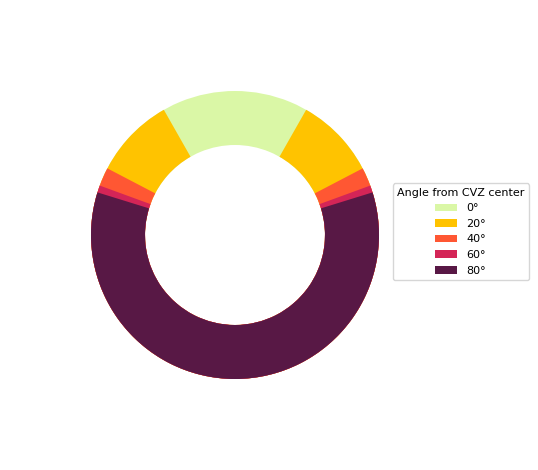

In [1]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
period = 100.9 # min
circle = 0.5
size = 0.3
hex = ['#DAF7A6', '#FFC300', '#FF5733', '#D42557', '#581845']
ViewingFrac = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=4)
index = [0,5,14,18,22]
angle = ['0°', '20°', '40°', '60°', '80°']
for n, time in enumerate([ViewingFrac[0]]+[ViewingFrac[4]]+[ViewingFrac[13]]+[ViewingFrac[17]]+[ViewingFrac[23]]):
    ring = [time, 1-time]
    wedges, labels = ax.pie(ring, radius=circle+size, startangle=90+360*ring[1]/2, colors=[hex[n], 'w'], 
                            labels=[angle[n],''], wedgeprops=dict(width=size, alpha=1))
    wedges[1].set_visible(False)
    labels[0].set_color('white')
ax.legend(title='Angle from CVZ center', loc=(0.85,0.4), title_fontsize=8, fontsize=8)
fig.tight_layout()
plt.savefig('viewing zone.pdf')

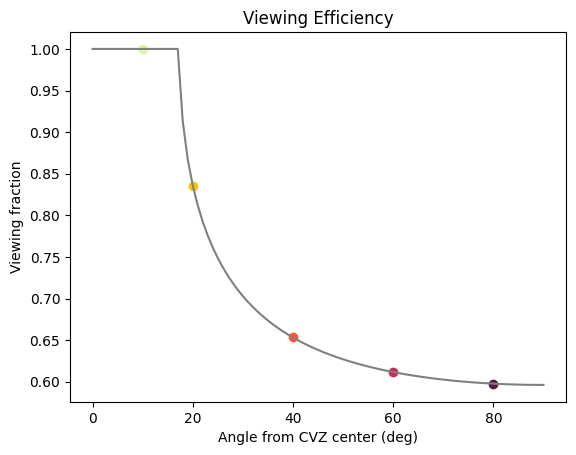

In [9]:
# Viewing Efficiency

# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
import math
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

angle = np.arange(0,91)
viewfrac = []
for theta_b in angle:
    viewfrac.append(ViewingFrac(theta_b))
plt.plot(angle, viewfrac, color='gray')
plt.scatter(10, ViewingFrac(10), color='#DAF7A6')
plt.scatter(20, ViewingFrac(20), color='#FFC300')
plt.scatter(40, ViewingFrac(40), color='#FF5733')
plt.scatter(60, ViewingFrac(60), color='#D42557')
plt.scatter(80, ViewingFrac(80), color='#581845')
plt.xlabel('Angle from CVZ center (deg)')
plt.ylabel('Viewing fraction')
plt.title('Viewing Efficiency')
plt.savefig('Viewing Efficiency.pdf')

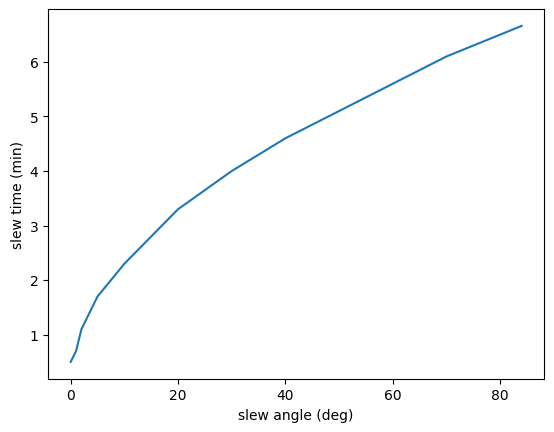

In [4]:
# Plot: Slew angle vs. Slew time

import numpy as np
import matplotlib.pyplot as plt

def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time
angle = np.arange(0, 85)
slew_time = []
for i in angle:
    slew_time.append(Angle2Time(i))
slew_time = np.array(slew_time)/60
plt.plot(angle, slew_time)
plt.xlabel('slew angle (deg)')
plt.ylabel('slew time (min)')
plt.show()